In [1]:
%matplotlib inline
import numpy as np
import time
import h5py
import keras
import pandas as pd
import math
import joblib
import matplotlib.pyplot as plt

from fuel.datasets.hdf5 import H5PYDataset

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from IPython.display import display

from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, Activation, 
                          Dropout, Conv2D, Conv2DTranspose, MaxPooling2D)
from keras.layers.merge import concatenate
from keras.regularizers import l2
from keras.initializers import RandomUniform
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import Model
from keras import metrics
from keras.utils import np_utils
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


# Load CIFAR10 dataset

In [2]:
ftrain = H5PYDataset("../../data/cifar10/cifar10.hdf5", which_sets=('train',))
X_train, y_train = ftrain.get_data(ftrain.open(), slice(0, ftrain.num_examples))
X_train = np.moveaxis(X_train[:], 1, 3)
X_train = X_train / 255.

ftest = H5PYDataset("../../data/cifar10/cifar10.hdf5", which_sets=('test',))
X_test, y_test = ftest.get_data(ftest.open(), slice(0, ftest.num_examples))
X_test = np.moveaxis(X_test[:], 1, 3)
X_test = X_test / 255.

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


# Variational Autoencoder Parameters

In [3]:
img_rows, img_cols, img_chns = 32, 32, 3

if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)

batch_size = 200
latent_dim = 512
intermediate_dim = 2048
epsilon_std = 1.0
epochs = 100
activation = 'relu'
dropout = 0.2
learning_rate = 0.0001
decay = 0.0
num_classes = 10

# Encoder Network

In [4]:
def create_enc_conv_layers(stage, **kwargs):
    conv_name = '_'.join(['enc_conv', str(stage)])
    bn_name = '_'.join(['enc_bn', str(stage)])
    layers = [
        Conv2D(name=conv_name, **kwargs),
        BatchNormalization(name=bn_name),
        Activation(activation),
    ]
    return layers

def create_dense_layers(stage, width):
    dense_name = '_'.join(['enc_conv', str(stage)])
    bn_name = '_'.join(['enc_bn', str(stage)])
    layers = [
        Dense(width, name=dense_name),
        BatchNormalization(name=bn_name),
        Activation(activation),
        Dropout(dropout),
    ]
    return layers

def inst_layers(layers, in_layer):
    x = in_layer
    for layer in layers:
        if isinstance(layer, list):
            x = inst_layers(layer, x)
        else:
            x = layer(x)
        
    return x

In [5]:
enc_filters=128
enc_layers = [
    create_enc_conv_layers(stage=1, filters=enc_filters, kernel_size=3, strides=1, padding='same'),
    create_enc_conv_layers(stage=2, filters=enc_filters // 2, kernel_size=3, strides=2, padding='same'),
    create_enc_conv_layers(stage=3, filters=enc_filters // 4, kernel_size=3, strides=2, padding='same'),
    Flatten(),
    create_dense_layers(stage=4, width=intermediate_dim),
]

In [6]:
# Labeled encoder
x_in = Input(batch_shape=(batch_size,) + original_img_size)
y_in = Input(batch_shape=(batch_size, num_classes))
_enc_dense = inst_layers(enc_layers, x_in)

_z_mean_1 = Dense(latent_dim)(_enc_dense)
_z_log_var_1 = Dense(latent_dim)(_enc_dense)

z_mean = _z_mean_1
z_log_var = _z_log_var_1

### Reparameterization Trick

In [7]:
def sampling(args, batch_size=batch_size, latent_dim=latent_dim, epsilon_std=epsilon_std):
    z_mean, z_log_var = args
    
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=epsilon_std)
    
    return z_mean + K.exp(z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Classifier Network 

In [8]:
classifier_layers = [
    Conv2D(32, (3, 3), padding='same'),
    Activation('relu'),
    Conv2D(32, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), padding='same'),
    Activation('relu'),
    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(512),
    Activation('relu'),
    Dropout(0.5),
    Dense(num_classes),
    Activation('softmax'),
]

In [9]:
_cls_output = inst_layers(classifier_layers, x_in)
_y_output = _cls_output

# Decoder Network

In [10]:
def create_dec_trans_conv_layers(stage, **kwargs):
    conv_name = '_'.join(['dec_trans_conv', str(stage)])
    bn_name = '_'.join(['dec_bn', str(stage)])
    layers = [
        Conv2DTranspose(name=conv_name, **kwargs),
        BatchNormalization(name=bn_name),
        Activation(activation),
    ]
    return layers

In [11]:
dec_filters = 128
decoder_layers = [
    create_dense_layers(stage=10, width=intermediate_dim),
    Reshape((8, 8, intermediate_dim // 64)),
    create_dec_trans_conv_layers(11, filters=dec_filters, kernel_size=3, strides=1, padding='same'),
    create_dec_trans_conv_layers(12, filters=dec_filters // 2, kernel_size=3, strides=2, padding='same'),
    create_dec_trans_conv_layers(13, filters=dec_filters // 4, kernel_size=3, strides=2, padding='same'),
    Conv2DTranspose(name='x_decoded', filters=3, kernel_size=1, strides=1, activation='sigmoid'),
]

In [12]:
# Labeled decoder
_merged = concatenate([y_in, z])
_dec_out = inst_layers(decoder_layers, _merged)
_x_output = _dec_out

# Unlabeled decoder
u_merged = concatenate([_y_output, z])
u_dec_out = inst_layers(decoder_layers, u_merged)
u_x_output = u_dec_out

# Loss Function

In [13]:
def kl_loss(x, x_decoded_mean, z_mean=z_mean, z_log_var=z_log_var):
    kl_loss = - 0.5 * K.sum(1. + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
   
    return K.mean(kl_loss)

def logxy_loss(x, x_decoded_mean):
    x = K.flatten(x)
    x_decoded_mean = K.flatten(x_decoded_mean)
    xent_loss = img_rows * img_cols * img_chns * metrics.binary_crossentropy(x, x_decoded_mean)
   
    # p(y) for observed data is equally distributed
    logy = np.log(1. / num_classes)
    
    return xent_loss - logy

def labeled_vae_loss(x, x_decoded_mean):
    return logxy_loss(x, x_decoded_mean) + kl_loss(x, x_decoded_mean)

def cls_loss(y, y_pred, N=1000):
    alpha = 0.1 * N
    return metrics.categorical_crossentropy(y, y_pred)

def unlabeled_vae_loss(x, x_decoded_mean):
    entropy = metrics.categorical_crossentropy(_y_output, _y_output)
    labeled_loss = logxy_loss(x, x_decoded_mean) + kl_loss(x, x_decoded_mean)
    
    return K.mean(K.sum(_y_output * labeled_loss, axis=-1)) + entropy

# Compile Model

In [14]:
label_vae = Model(inputs=[x_in, y_in], outputs=[_x_output, _y_output])
optimizer = Adam(lr=learning_rate, decay=decay)
label_vae.compile(optimizer=optimizer, loss=[labeled_vae_loss, cls_loss])
label_vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (200, 32, 32, 3)      0                                            
____________________________________________________________________________________________________
enc_conv_1 (Conv2D)              (200, 32, 32, 128)    3584        input_1[0][0]                    
____________________________________________________________________________________________________
enc_bn_1 (BatchNormalization)    (200, 32, 32, 128)    512         enc_conv_1[0][0]                 
____________________________________________________________________________________________________
activation_1 (Activation)        (200, 32, 32, 128)    0           enc_bn_1[0][0]                   
___________________________________________________________________________________________

In [15]:
unlabeled_vae = Model(inputs=x_in, outputs=u_x_output)
optimizer = Adam(lr=learning_rate, decay=decay)
unlabeled_vae.compile(optimizer=optimizer, loss=unlabeled_vae_loss)
unlabeled_vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (200, 32, 32, 3)      0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (200, 32, 32, 32)     896         input_1[0][0]                    
____________________________________________________________________________________________________
activation_5 (Activation)        (200, 32, 32, 32)     0           conv2d_1[0][0]                   
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (200, 30, 30, 32)     9248        activation_5[0][0]               
___________________________________________________________________________________________

In [16]:
from tqdm import tnrange, tqdm_notebook
def fit_model(X_unlabeled, X_labeled, y_labeled, epochs):
    assert len(X_unlabeled) % len(X_labeled) == 0, \
            (len(X_unlabeled), batch_size, len(X_labeled))
    start = time.time()
    history = []
    
    for epoch in tnrange(epochs):
        unlabeled_index = np.arange(len(X_unlabeled))
        np.random.shuffle(unlabeled_index)
        
        # Repeat the labeled data to match length of unlabeled data
        labeled_index = []
        for i in range(len(X_unlabeled) // len(X_labeled)):
            l = np.arange(len(X_labeled))
            np.random.shuffle(l)
            labeled_index.append(l)
        labeled_index = np.concatenate(labeled_index)
        
        batches = len(X_unlabeled) // batch_size
        with tnrange(batches, leave=False) as pbar:
            for i in range(batches):
                # Labeled
                index_range =  labeled_index[i * batch_size:(i+1) * batch_size]
                loss = label_vae.train_on_batch([X_labeled[index_range], y_labeled[index_range]], 
                                                [X_labeled[index_range], y_labeled[index_range]])
                
                # Unlabeled
                index_range =  unlabeled_index[i * batch_size:(i+1) * batch_size]
                loss += [unlabeled_vae.train_on_batch(X_unlabeled[index_range],  X_unlabeled[index_range])]
                pbar.desc = 'Loss: %s' % loss
                history.append(loss)
                
                pbar.update(1)
    
   
    done = time.time()
    elapsed = done - start
    print("Elapsed: ", elapsed)
    
    return history

In [17]:
sample_size = 1000
start = time.time()
print('Fitting with sample_size: {}'.format(sample_size))

if sample_size < len(X_train):
    sss = StratifiedShuffleSplit(n_splits=2, test_size=sample_size / len(X_train), random_state=0)
    _, index = sss.split(X_train, y_train)
    X, y = X_train[index[1]], y_train[index[1]]
    X_others, _ = X_train[index[0]], y_train[index[0]]
else:
    X, y = X_train, y_train

y = np_utils.to_categorical(y)

history = fit_model(X_others, X, y, epochs=epochs)

classifier = Model(inputs=[x_in], outputs=[_y_output])

y_pred = np.argmax(classifier.predict(X_test, batch_size=batch_size), axis=-1)
score = accuracy_score(y_test, y_pred)

end = time.time()
elapsed = end - start
print(' * Accuracy: %.1f %%' % (100. * score))
print(' * Fit time elapsed: %.1fs' % elapsed)

results = []
results.append({'sample_size': sample_size, 'accuracy': score, 'time': elapsed})

Fitting with sample_size: 1000

Elapsed:  6456.381057024002
 * Accuracy: 41.9 %
 * Fit time elapsed: 6457.3s


,labeled_loss,labeled_loss2,classifier_loss,unlabeled_loss
count,24500.000000,24500.000000,2.450000e+04,24500.000000
mean,1806.074185,1805.894155,1.800298e-01,1826.090685
std,169.576388,169.422063,5.385715e-01,48.174914
min,1718.777832,1718.777588,9.170336e-07,1743.896484
0%,1718.777832,1718.777588,9.170336e-07,1743.896484
25%,1780.415375,1780.397491,3.051035e-03,1804.386536
50%,1793.668152,1793.636169,1.868162e-02,1817.218140
75%,1810.991821,1810.919312,6.200992e-02,1832.272125
95%,1885.506342,1884.310626,1.328240e+00,1896.097028
99%,1994.350668,1991.287073,3.128265e+00,2003.364639


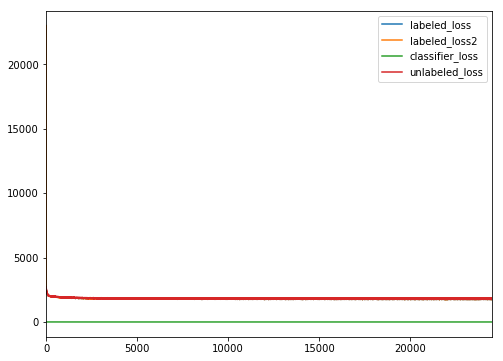

In [18]:
df = pd.DataFrame(history, columns=['labeled_loss', 'labeled_loss2', 'classifier_loss', 'unlabeled_loss'])
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df.plot(figsize=(8, 6))

# Generator Network

In [19]:
g_y = Input(shape=(num_classes,))
g_z = Input(shape=(latent_dim,))
g_merged = concatenate([g_y, g_z])
g_output = inst_layers(decoder_layers, g_merged)
generator = Model([g_y, g_z], g_output)

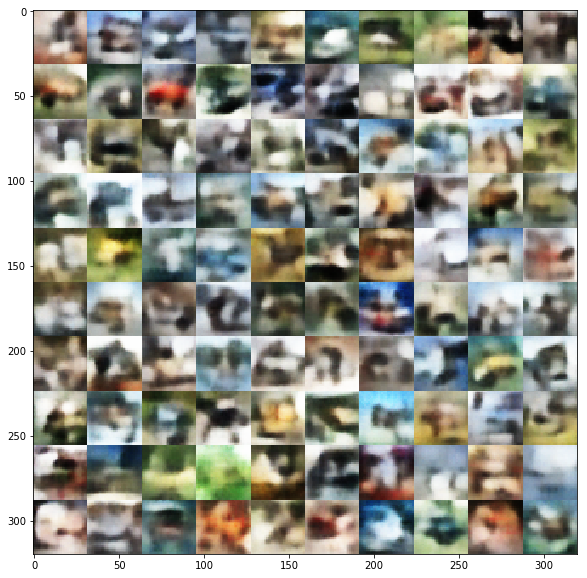

In [20]:
import matplotlib.pyplot as plt
n = 10
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n, img_chns))

for j in range(n):
    for i in range(n):
        y_sample = np.zeros(num_classes).reshape(1, num_classes)
        y_sample[0, i] = 1
        z_sample = np.random.normal(size=latent_dim).reshape(1, latent_dim)
        x_decoded = generator.predict([y_sample, z_sample], batch_size=1)
        digit = x_decoded.reshape(digit_size, digit_size, img_chns)
        
        d_x = i * digit_size
        d_y = j * digit_size
        figure[d_x:d_x + digit_size, d_y:d_y + digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [21]:
df = pd.DataFrame(results)
display(df)
df.to_csv('vae-m2_results.csv', index=False)

,accuracy,sample_size,time
0,0.4194,1000,6457.317263
